# Getting Started With Our Analysis

## Loading in the saved dataset and our tools:
So, to get started we're going to pull the pkl file that I saved our last dataset to - the one that we cleaned up and truncated down. It's still a pretty hefty 21K rows, so we've still got plenty to play with this time.

We're basically going to make use of the same tools this time, except we're also going to bring in statsmodels to run quick OLS tests on variations of our final model. Let's get started.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

In [2]:
#Load in the saved csv, check for quality
df = pd.read_csv('df_cleaned.csv')
df.head()

,Unnamed: 0,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,7129300520,2014-10-13,221900.0,3.0,1.00,1180,5650,1.0,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,1,6414100192,2014-12-09,538000.0,3.0,2.25,2570,7242,2.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,2,5631500400,2015-02-25,180000.0,2.0,1.00,770,10000,1.0,0.0,...,6,770,0.0,1933,0.0,98028,47.7379,-122.233,2720,8062
3,3,2487200875,2014-12-09,604000.0,4.0,3.00,1960,5000,1.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,4,1954400510,2015-02-18,510000.0,3.0,2.00,1680,8080,1.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [3]:
#CSV has brought in an extra index column, this will get rid of it
df.drop('Unnamed: 0', axis = 1, inplace = True)
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,2014-10-13,221900.0,3.0,1.00,1180,5650,1.0,0.0,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,2014-12-09,538000.0,3.0,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2015-02-25,180000.0,2.0,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,0.0,98028,47.7379,-122.233,2720,8062
3,2487200875,2014-12-09,604000.0,4.0,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2015-02-18,510000.0,3.0,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [4]:
#Since we reloaded a CSV, we lost the datetime obj type. Reapplying. Confirming.
df['date'] = pd.to_datetime(df.date)
df.dtypes

id                        int64
date             datetime64[ns]
price                   float64
bedrooms                float64
bathrooms               float64
sqft_living               int64
sqft_lot                  int64
floors                  float64
waterfront              float64
view                    float64
condition                 int64
grade                     int64
sqft_above                int64
sqft_basement           float64
yr_built                  int64
yr_renovated            float64
zipcode                   int64
lat                     float64
long                    float64
sqft_living15             int64
sqft_lot15                int64
dtype: object

## Check the data for multicolinearity

Before we can move forward with selecting variables, we want to make sure that we deselect those which highly correlate with each other, as they can introduce unnecessary error into our models and interfere with the way we may seek to answer questions.

Text(0.5, 1.0, 'Pearson Correlation > 0.75')

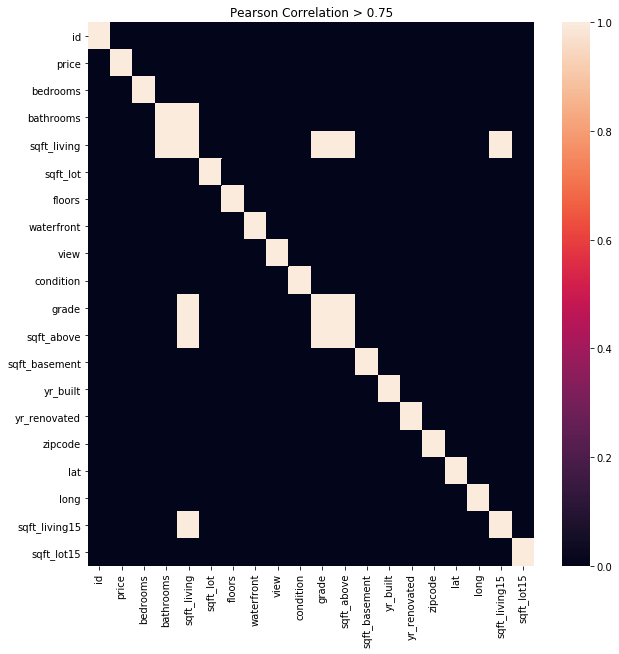

In [5]:
#Heatmap of T/F values to identify muticolinear variables
#Easier to read than a standard heatmap
fig = plt.figure(figsize=(10,10))
sns.heatmap(df.corr() > 0.75)
plt.title("Pearson Correlation > 0.75")

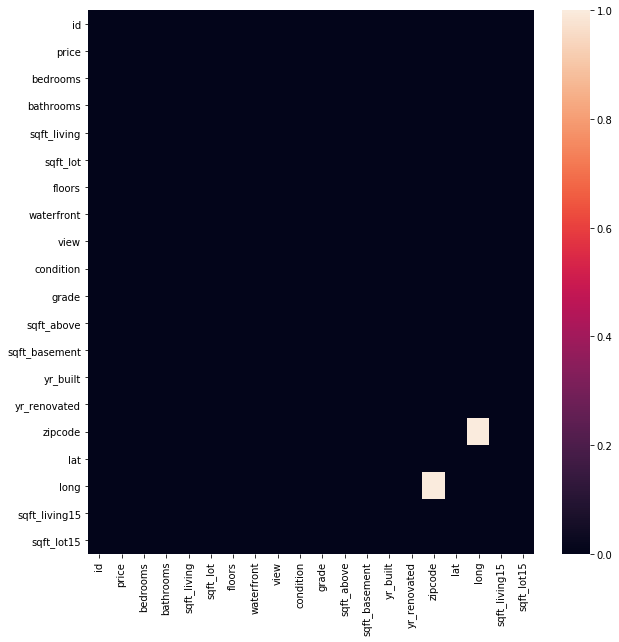

In [6]:
#Check for negative MCL
fig = plt.figure(figsize=(10,10))
sns.heatmap(df.corr() < -0.5)

From here, we can see that to stay safe, we're going to assume the following features are colinear with each other:

1. `sqft_living` is colinear with `sqft_living15` and `sqft_above`.
2. `sqft_living` is also colinear with `bathrooms` and `grade`.
3. `grade` is colinear with `sqft_above`.
4. `zipcode` is negatively correlated with `longitude`.

This means that once we are running our model, we want to avoid incorporating `sqft_living` with any of those four fields. However, we could combine some of these features since mostly they only highly correlate with `sqft_living`. I'll illustrate below.

Text(0, 0.5, 'sqft_living15')

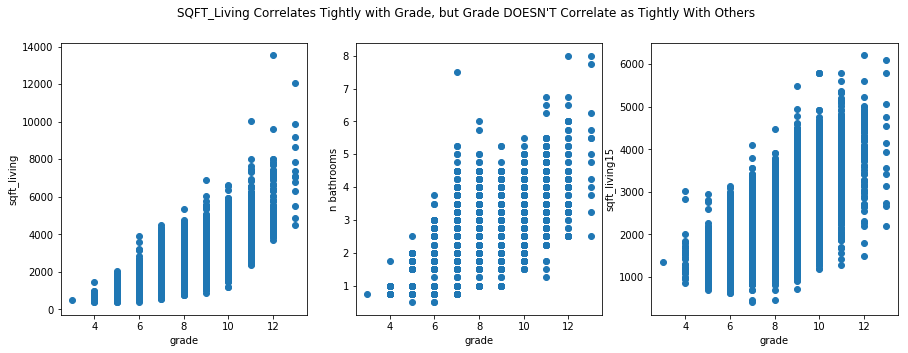

In [7]:
#Creating a figure to illustrate what these Pearson values look like
fig = plt.figure(figsize=(15,5))
fig.suptitle("SQFT_Living Correlates Tightly with Grade, but Grade DOESN'T Correlate as Tightly With Others")

#Grade vs sqft_living, Corr > 0.75
ax1 = fig.add_subplot(1,3,1)
ax1.scatter(df.grade, df.sqft_living)
ax1.set_xlabel('grade')
ax1.set_ylabel('sqft_living')

#Grade vs n Bathrooms, Corr < 0.75
ax2 = fig.add_subplot(1,3,2)
ax2.scatter(df.grade, df.bathrooms)
ax2.set_xlabel('grade')
ax2.set_ylabel('n bathrooms')

#Grade vs sqft_living15, Corr < 0.75
ax3 = fig.add_subplot(1,3,3)
ax3.scatter(df.grade, df.sqft_living15)
ax3.set_xlabel('grade')
ax3.set_ylabel('sqft_living15')

### Check the continuous data for normality

Since we're going to be focused on what's going to work well in predicting price, we want to see how close it is to a standard distribution as-is, and see if maybe we want to normalize it from there. We're just going to take a quick look at a histogram of price and its KDE.

Text(0.5, 1.0, 'Distribution of Price w/ Probability Curve')

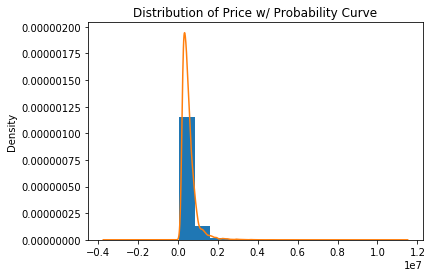

In [8]:
#Plot histogram w/ probability density to check distribution
plt.hist(df['price'], density = True)
df['price'].plot.kde()
plt.title("Distribution of Price w/ Probability Curve")

This is not looking like normally distributed data, so we're going to transform it. Simplest option is always a log transform, as I don't have to load in any extra formulas.

Text(0.5, 1.0, 'Distribution of Pricelog w/ Probability Curve')

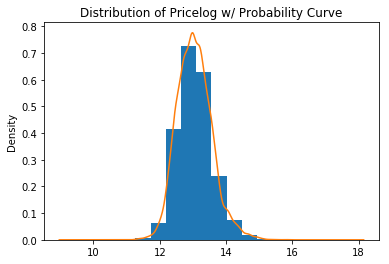

In [9]:
#Apply log transform
df['pricelog'] = np.log(df['price'])

#Check distribution with probability density histogram again
plt.hist(df['pricelog'], density = True)
df['pricelog'].plot.kde()
plt.title("Distribution of Pricelog w/ Probability Curve")

Now that `Price` is normally distributed, let's check for relationships.

# Answering Meaningful Questions

## What are the main drivers of sale price? Are they controllable?

Now that we've got our dataset normalized and we can understand what corresponds to what, we can start answering questions about our data. To answer what drives sale price, we can take a look at what correlates well with sale price:

Text(0.5, 1.0, "Pearson Correlation Values of 'Pricelog'")

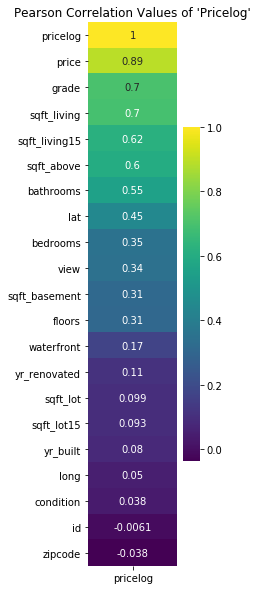

In [10]:
#Create a single-column DataFrame for pricelog that containts its pearson correlation values; sort it descending
Corr = df.corr()
Corr_pricelog = pd.DataFrame(Corr['pricelog'])
Corr_pricelog.sort_values('pricelog', ascending = False, inplace = True)

#Create heatmap to visually represent correlation values; add annotations to show degree of correlation
fig = plt.figure(figsize=(2,10))
sns.heatmap(Corr_pricelog, annot=True, cmap='viridis')
plt.title("Pearson Correlation Values of 'Pricelog'")

From here we can see that very consistently `pricelog` correlate closely with `grade` and `sqft_living`. Once we start getting into our models, wen can look a little deeper at how valuable these are as predictors, but it's no surprise based on what we know:  it makes sense that our strongest drivers are total square footage of the floor plan, and a categorical measurement that ranks from 'Cabins' to 'Mansions,' with mansions having higher sale prices.

That is to say, it shouldn't be surprising that the bigger the house, the higher the price; and concurrently, the better the build quality, the higher the price.

As a home builder, these are very controllable:  if a series of lots are acquired and you want to maximize price, you want to maximize the individual square footage allotted to a house; and once you've set on a floor plan, you want to maximize on material and build quality.

#### To test this out, we can try and see what a model would look like if it was made using only `sqft_living` or `grade`.

In [11]:
#Single variable OLS model to see how much Grade can describe on its own
model_q1a = ols(formula = 'pricelog ~ grade', data=df).fit()
model_q1a.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               pricelog   R-squared:                       0.495
Model:                            OLS   Adj. R-squared:                  0.495
Method:                 Least Squares   F-statistic:                 2.066e+04
Date:                Sun, 23 Jun 2019   Prob (F-statistic):               0.00
Time:                        02:57:24   Log-Likelihood:                -9172.9
No. Observations:               21054   AIC:                         1.835e+04
Df Residuals:                   21052   BIC:                         1.837e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.6321      0.017    624.993      0.000      10.599      10.665
grade          0.3156      0.002    143.752      0.000       0.311       0.320
==============================================================================
Omnibus:                      133.048   Durbin-Watson:                   1.965
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              136.615
Skew:                           0.186   Prob(JB):                     2.16e-30
Kurtosis:                       3.132   Cond. No.                         52.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

As we can see, a model that's based only on `grade` can pretty thoroughly explain about half the variation we see in our data - so, it's safe to say that this feature is driving price.

## How much do bedrooms, bathrooms, and floors impact sale price?

As a customer, you're usually concerned with the price that you're going to pay, and the number of bed/baths you're going to get. So, to evaluate how much those customer choices drive price, we can take a look again at `df.corr` and then check in with some linear regression modeling

Text(0.5, 1.0, "Pearson Correlation Values of 'Pricelog'")

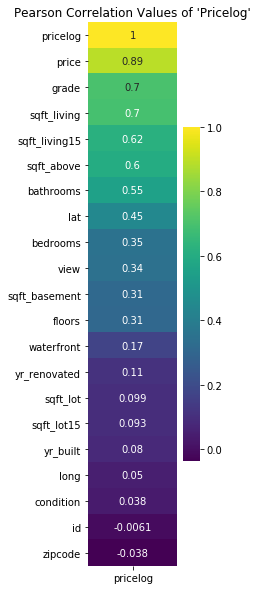

In [12]:
#Plot the same heat map as before
fig = plt.figure(figsize=(2,10))
sns.heatmap(Corr_pricelog, annot=True, cmap='viridis')
plt.title("Pearson Correlation Values of 'Pricelog'")

At this point it looks like `bathrooms` could have a pretty big impact, but honestly, with `bedrooms` and `floors` correlating as poorly as they do, it looks like including them might hurt our model, but let's take a look.

In [13]:
#This will see how well bathrooms' can describe the model on its own
model_q2a = ols(formula = 'pricelog ~ bathrooms', data=df).fit()
model_q2a.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               pricelog   R-squared:                       0.304
Model:                            OLS   Adj. R-squared:                  0.304
Method:                 Least Squares   F-statistic:                     9201.
Date:                Sun, 23 Jun 2019   Prob (F-statistic):               0.00
Time:                        02:57:24   Log-Likelihood:                -12555.
No. Observations:               21054   AIC:                         2.511e+04
Df Residuals:                   21052   BIC:                         2.513e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.2501      0.009   1381.983      0.000      12.233      12.268
bathrooms      0.3775      0.004     95.920      0.000       0.370       0.385
==============================================================================
Omnibus:                      188.776   Durbin-Watson:                   1.964
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              193.682
Skew:                           0.233   Prob(JB):                     8.76e-43
Kurtosis:                       3.058   Cond. No.                         7.77
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [14]:
#Add in all the usual 'selectable' features of beds, baths, and floors; compare R^2
model_q2b = ols(formula = 'pricelog ~ bathrooms + bedrooms + floors', data=df).fit()
model_q2b.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               pricelog   R-squared:                       0.311
Model:                            OLS   Adj. R-squared:                  0.311
Method:                 Least Squares   F-statistic:                     3171.
Date:                Sun, 23 Jun 2019   Prob (F-statistic):               0.00
Time:                        02:57:24   Log-Likelihood:                -12447.
No. Observations:               21054   AIC:                         2.490e+04
Df Residuals:                   21050   BIC:                         2.493e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.1041      0.013    911.436      0.000      12.078      12.130
bathrooms      0.3268      0.005     61.880      0.000       0.316       0.337
bedrooms       0.0523      0.004     13.230      0.000       0.045       0.060
floors         0.0515      0.007      7.918      0.000       0.039       0.064
==============================================================================
Omnibus:                      192.663   Durbin-Watson:                   1.962
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              197.773
Skew:                           0.236   Prob(JB):                     1.13e-43
Kurtosis:                       3.054   Cond. No.                         20.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

This seems to confirm that, just looking at our R-squared values, bathrooms alone explain far less of the model than total square footage - and worse, combining bathrooms with other features like bedrooms and floors doesn't improve the model very much. It's safe to say at this point that building a house meant to maximize on those features won't drive the price very well.

## Where are the new housing developments? What are those units selling for?

Our dataset comes with a `yr_built` feature and also includes `lat` and `long` coordinates, so we should be able to identify newer developments and plot them out versus their peers.

In [15]:
#Groupby yearbuilt, examine last rows to see most recent years in dataframe
df.groupby('yr_built').count().tail()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,pricelog
yr_built,,,,,,,,,,,,,,,,,,,,,
2011,127,127,127,127,127,127,127,127,127,127,...,127,127,127,127,127,127,127,127,127,127
2012,163,163,163,163,163,163,163,163,163,163,...,163,163,163,163,163,163,163,163,163,163
2013,200,200,200,200,200,200,200,200,200,200,...,200,200,200,200,200,200,200,200,200,200
2014,547,547,547,547,547,547,547,547,547,547,...,547,547,547,547,547,547,547,547,547,547
2015,35,35,35,35,35,35,35,35,35,35,...,35,35,35,35,35,35,35,35,35,35


In [16]:
#Filter more recent builds into a separate DF
recent_builds = df.loc[df['yr_built'] >= 2014]
recent_builds.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,pricelog
40,7203220400,2014-07-07,861990.0,5.0,2.75,3595,5639,2.0,0.0,0.0,...,3595,0.0,2014,0.0,98053,47.6848,-122.016,3625,5639,13.666999
61,9528102996,2014-12-07,549000.0,3.0,1.75,1540,1044,3.0,0.0,0.0,...,1540,0.0,2014,0.0,98115,47.6765,-122.320,1580,3090,13.215854
129,8929000270,2014-05-12,453246.0,3.0,2.50,2010,2287,2.0,0.0,0.0,...,1390,620.0,2014,0.0,98029,47.5517,-121.998,1690,1662,13.024190
135,2767603505,2014-05-07,519950.0,3.0,2.25,1170,1249,3.0,0.0,0.0,...,1170,0.0,2014,0.0,98107,47.6722,-122.381,1350,1310,13.161488
205,1025049114,2014-07-17,625504.0,3.0,2.25,1270,1566,2.0,0.0,0.0,...,1060,210.0,2014,0.0,98105,47.6647,-122.284,1160,1327,13.346313


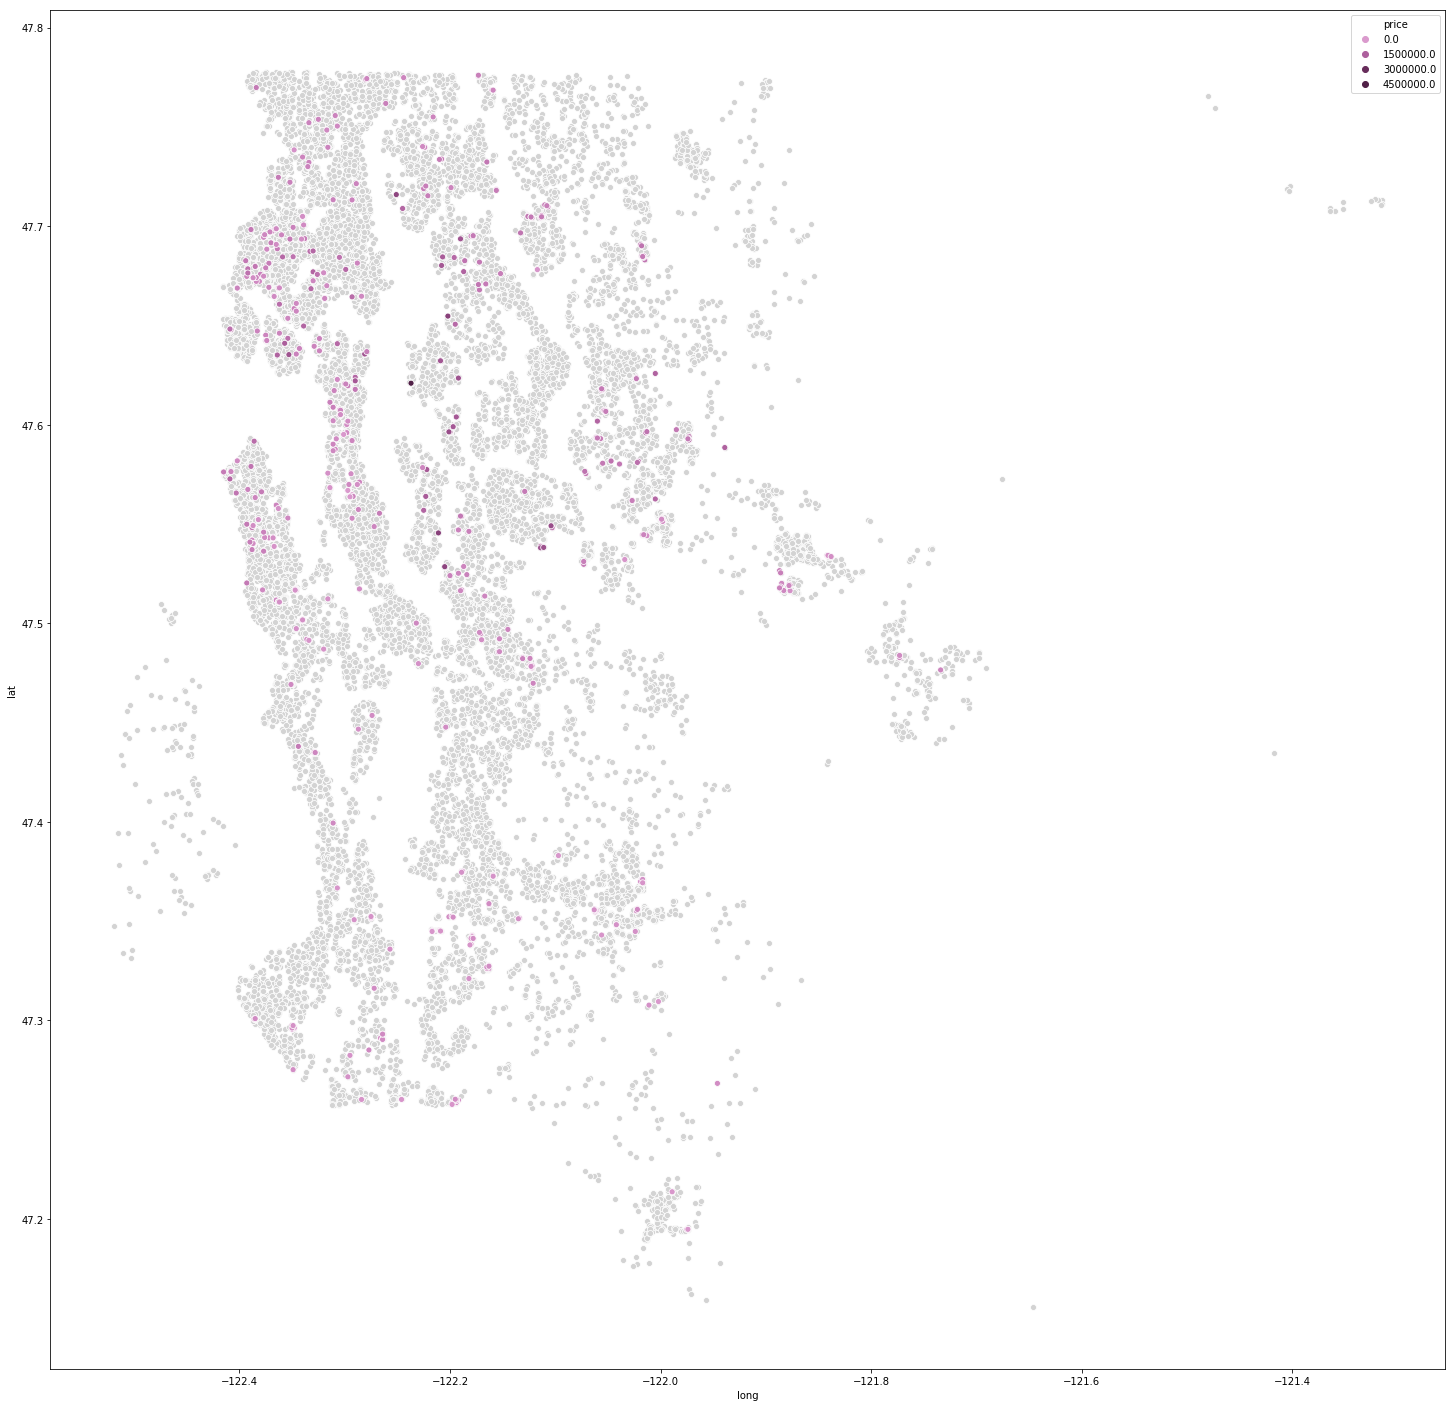

In [17]:
fig = plt.figure(figsize=(25,25))

#ALL sales in set, represents map background
sns.scatterplot(x=df.long, y=df.lat, color = 'lightgrey')

#Only most recent set, with hue set as a fxn of 'price' to show both location and price data
sns.scatterplot(x=recent_builds.long, y=recent_builds.lat, hue=recent_builds['price'],
                palette = "ch:0.5,h=1,r=0,l=0.7,d=.2")

In [18]:
#Descriptive stats of recent builds
recent_builds['price'].describe()

count    5.820000e+02
mean     6.876867e+05
std      3.803609e+05
min      1.750030e+05
25%      4.299840e+05
50%      5.990000e+05
75%      8.399800e+05
max      3.420000e+06
Name: price, dtype: float64

So, from here we can plainly see that a lot of the growth in new housing is just north of Seattle. There's definitely some interspersed development, but we can see it really clustering close to the city center and just north of it. By using some descriptive statistics we can see that the minimum a new house sells for is 175K, while the median house price is 599K.

We can also see that some of the very expensive houses are clustered on that island just west of Seattle.

## Where are house prices the highest? Where are they the lowest?

From here we can take a look at where housing values are clustered. We should expect higher prices closer to downtown, and lower prices the farther away we are from Seattle.

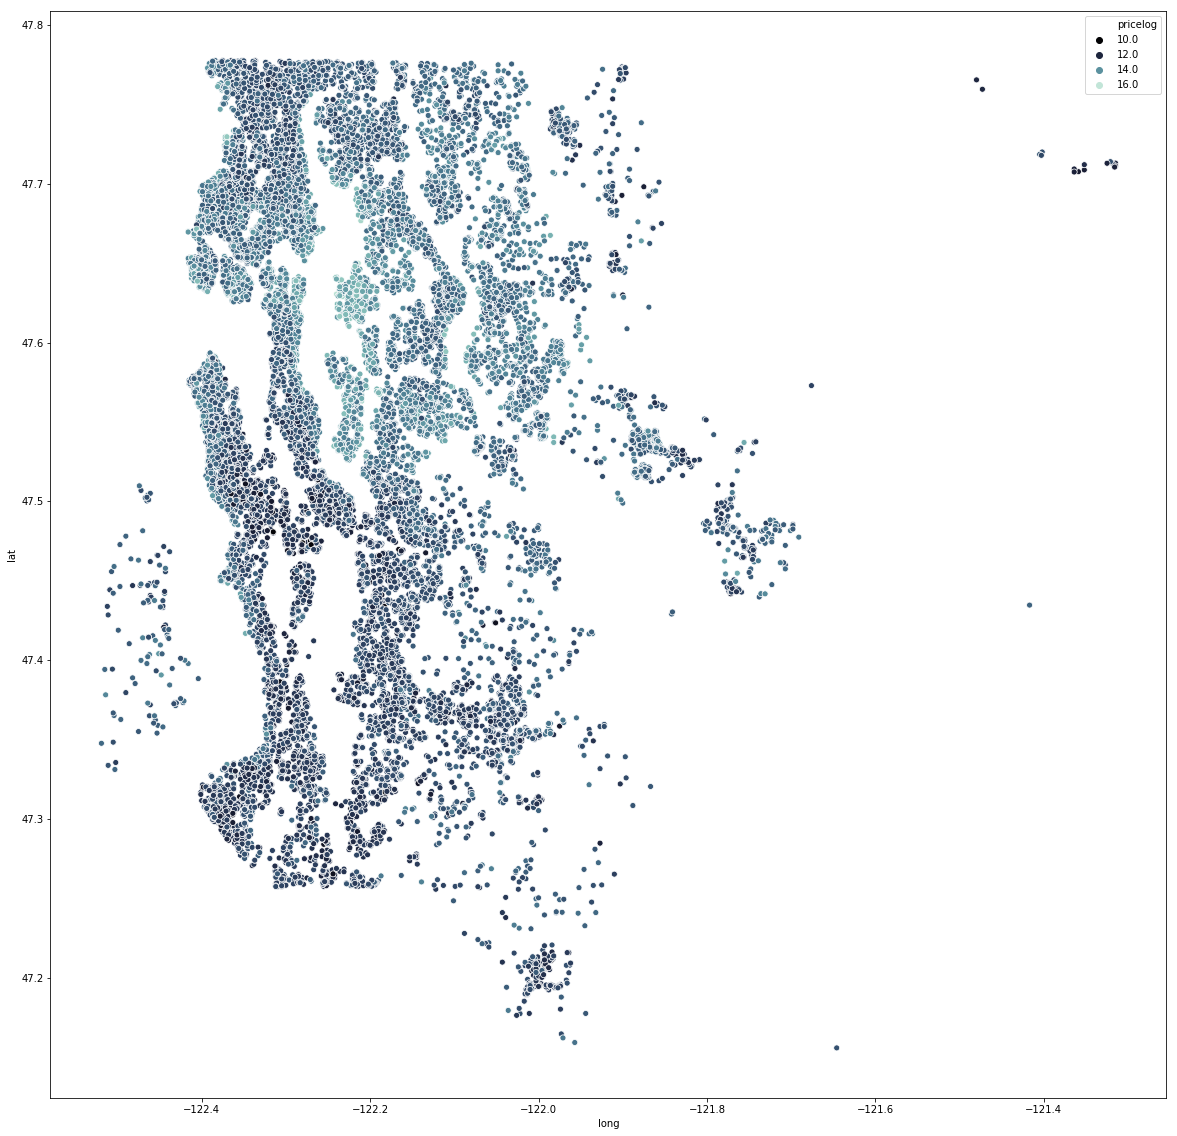

In [19]:
#Similar trick as above:  all plot points w/ pricelog set to hue to visually display price distribution
f, ax = plt.subplots(figsize=(20, 20))
sns.scatterplot(x=df.long, y=df.lat,
                hue=df.pricelog,
                palette="ch:r=-.3,d=0.01_r",
                data=df, ax=ax)

## Getting Started With Modeling

First things first, we're going to pare down our dataframe and split it so that it'll work easily with SciKit Learn.

In [20]:
#Survey how many columns I currently have
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'pricelog'],
      dtype='object')

In [21]:
#Create y variable, in anticipation of using SciKit Learn
y = df.pricelog
y.head()

0    12.309982
1    13.195614
2    12.100712
3    13.311329
4    13.142166
Name: pricelog, dtype: float64

In [23]:
#Precursor to X variable; dropping unnecessary columns and MCL columns from dataset
predictors = df.drop(['id', 'date', 'price', 'sqft_living', 'sqft_lot', 'sqft_living15', 'sqft_above', 'pricelog'], axis=1)
predictors.head()

,bedrooms,bathrooms,floors,waterfront,view,condition,grade,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_lot15
0,3.0,1.00,1.0,0.0,0.0,3,7,0.0,1955,0.0,98178,47.5112,-122.257,5650
1,3.0,2.25,2.0,0.0,0.0,3,7,400.0,1951,1991.0,98125,47.7210,-122.319,7639
2,2.0,1.00,1.0,0.0,0.0,3,6,0.0,1933,0.0,98028,47.7379,-122.233,8062
3,4.0,3.00,1.0,0.0,0.0,5,7,910.0,1965,0.0,98136,47.5208,-122.393,5000
4,3.0,2.00,1.0,0.0,0.0,3,8,0.0,1987,0.0,98074,47.6168,-122.045,7503


### Selecting features

We're going to let scikit select some features with its built in recursive feature elimination.

In [24]:
#Load LinearRegresion and Recursive Feature Elimination, apply RFE to X and y
linreg = LinearRegression()
selector = RFE(linreg, n_features_to_select=5)
selector = selector.fit(predictors, y)

In [25]:
#Use boolean mask to pop out names of selected columns
selector.support_ * np.array(predictors.columns)

array(['', 'bathrooms', '', 'waterfront', '', 'condition', 'grade', '',
       '', '', '', 'lat', '', ''], dtype=object)

So, we can see that based on coeffecients, scikit selected `bathrooms`, `waterfront`, `condition`, `grade`, and `lat` as our five best predictors. Let's see a summary of what a model would look like with these selctions by looking at a model summary from StatsModels.

In [26]:
#Run StatsModels on SKL determined variables
model = ols(formula = 'pricelog ~ grade + lat + waterfront + condition + bathrooms', data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               pricelog   R-squared:                       0.688
Model:                            OLS   Adj. R-squared:                  0.688
Method:                 Least Squares   F-statistic:                     9271.
Date:                Sun, 23 Jun 2019   Prob (F-statistic):               0.00
Time:                        02:58:03   Log-Likelihood:                -4120.0
No. Observations:               21054   AIC:                             8252.
Df Residuals:                   21048   BIC:                             8300.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -59.3138      0.701    -84.605      0.000     -60.688     -57.940
grade          0.2448      0.002    104.187      0.000       0.240       0.249
lat            1.4677      0.015     99.347      0.000       1.439       1.497
waterfront     0.7435      0.025     30.289      0.000       0.695       0.792
condition      0.1190      0.003     37.729      0.000       0.113       0.125
bathrooms      0.1298      0.004     36.589      0.000       0.123       0.137
==============================================================================
Omnibus:                      660.444   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              875.682
Skew:                           0.354   Prob(JB):                    7.05e-191
Kurtosis:                       3.705   Cond. No.                     1.67e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.67e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Since recursive feature elimination only takes into account the weight of the coefficients in the proposed model, it ignores R-squared. However, this seems to have returned a pretty strong value for R-squared, but after some experimentation I found that adding in `yr_built` significantly improved our R-squared value as well.

In [27]:
#Trial and Error, adding in another variable. Adding in yr_built jumped us up to 0.723.
model = ols(formula = 'pricelog ~ grade + lat + waterfront + condition + bathrooms + yr_built', data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               pricelog   R-squared:                       0.723
Model:                            OLS   Adj. R-squared:                  0.723
Method:                 Least Squares   F-statistic:                     9175.
Date:                Sun, 23 Jun 2019   Prob (F-statistic):               0.00
Time:                        02:58:06   Log-Likelihood:                -2842.4
No. Observations:               21054   AIC:                             5699.
Df Residuals:                   21047   BIC:                             5754.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -42.6515      0.733    -58.172      0.000     -44.089     -41.214
grade          0.2666      0.002    118.485      0.000       0.262       0.271
lat            1.2965      0.014     90.746      0.000       1.268       1.324
waterfront     0.6487      0.023     27.993      0.000       0.603       0.694
condition      0.0617      0.003     19.478      0.000       0.055       0.068
bathrooms      0.1874      0.004     53.282      0.000       0.181       0.194
yr_built      -0.0044   8.38e-05    -52.113      0.000      -0.005      -0.004
==============================================================================
Omnibus:                      474.228   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              825.130
Skew:                           0.193   Prob(JB):                    6.69e-180
Kurtosis:                       3.890   Cond. No.                     7.57e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.57e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Train-Test Splitting

From here we're going to try the proposed model on train/test splits from our full data set. The test model, here named `model_test`, will run on the variables we've selected to check for model fitness, overfitness, and distribution of its residuals.

In [28]:
#X will be even more pared down than before, to just what we want to test
X = predictors[['grade','lat', 'waterfront', 'condition', 'bathrooms','yr_built']]

linreg = LinearRegression() #This was previously defined, but I copied it here for reference

#Define train/test size and model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
model_test = linreg.fit(X_train, y_train)

#Use model to generate predicted values on both train and test sets
y_hat_train = model_test.predict(X_train)
y_hat_test = model_test.predict(X_test)

In [29]:
#Use predicted values of sets to determine MSE of both
mse_train = np.sum((y_train-y_hat_train)**2/len(y_train))
mse_test = np.sum((y_test-y_hat_test)**2/len(y_test))
print('Train MSE:', mse_train)
print('Test MSE:', mse_test)

#Use .score to return R^2 of current test
R_squared = model_test.score(X_test, y_test)
print('This iteration has an R-squared value of:', R_squared)

Train MSE: 0.0761467594849774
Test MSE: 0.07895089051022339
This iteration has an R-squared value of: 0.7154008620172978


So far it's looking like our training MSE and test MSE are close, so it doesn't look like we're overfit; and our $R^2$ value is still over 70%, so it still seems to be well fit.

(array([  19.,   78.,  361., 1623., 5047., 6245., 2815.,  572.,   70.,
          13.]),
 array([-1.33509934, -1.07678764, -0.81847595, -0.56016425, -0.30185256,
        -0.04354086,  0.21477084,  0.47308253,  0.73139423,  0.98970592,
         1.24801762]),
 <a list of 10 Patch objects>)

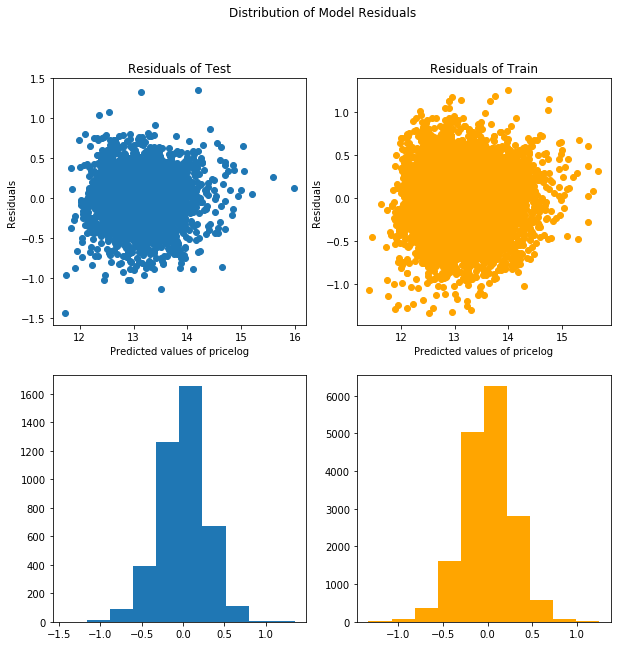

In [30]:
#Residuals check
#Define residuals as predicted less observed
residuals_train = y_hat_train - y_train
residuals_test = y_hat_test - y_test

fig = plt.figure(figsize=(10,10))
fig.suptitle("Distribution of Model Residuals")

ax1 = fig.add_subplot(2,2,1) #Scatterplot of test residuals
ax1.scatter(x=y_hat_test, y=residuals_test)
ax1.set_title('Residuals of Test')
ax1.set_xlabel('Predicted values of pricelog')
ax1.set_ylabel('Residuals')

ax2 = fig.add_subplot(2,2,2) #Scatterplot of train residuals
ax2.scatter(x=y_hat_train, y=residuals_train, c='orange')
ax2.set_title('Residuals of Train')
ax2.set_xlabel('Predicted values of pricelog')
ax2.set_ylabel('Residuals')

ax3 = fig.add_subplot(2,2,3) #Histogram of test residuals
ax3.hist(residuals_test) 

ax4 = fig.add_subplot(2,2,4) #Histogram of train residuals
ax4.hist(residuals_train, color='orange')

It also looks like our residuals are normally distributed, so we've passed the test of homoscedasticity. Altogether, it looks 

# The Final Model

In [31]:
#Storing good model in the variable modelF
modelF = linreg.fit(X, y)

#Create dictionary matching variable names to their corresponding coeffs
var_coefs = dict(zip(X.columns, modelF.coef_))

#Display variable names and coeffs
print("The variables and their corresponding coefficients are:")
var_coefs

The variables and their corresponding coefficients are:


{'grade': 0.2666483860598647,
 'lat': 1.2964508560090016,
 'waterfront': 0.6486916952879137,
 'condition': 0.061663666163097555,
 'bathrooms': 0.18743670256253803,
 'yr_built': -0.004369584624496214}

In [32]:
print("The intercept is:", modelF.intercept_)

The intercept is: -42.65149553246081


Our model is intended to follow this formula:

> $ln(Price) = \alpha (Grade) + 
              \beta (Latitude) + 
              \gamma (Waterfront) + 
              \delta (Condition) + 
              \epsilon (Bathrooms) + 
              \zeta (Year Built) +
              Intercept$ 

So we can plug in the coefficients provided to express that:

>$ln(Price) = \frac {133}{500}\ Grade + 
              \frac {162}{125}\ Latitude + 
              \frac {81}{125}\ Waterfront + 
              \frac {77}{1250}\ Condition + 
              \frac {187}{1000}\ Bathrooms - 
              \frac {1}{250} Year Built -
              42.651$